Data from: https://www.kaggle.com/datasets/undersc0re/predict-the-churn-risk-rate

## Import Packages

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


import scikitplot as skplt
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config(display= 'diagram')
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, ConfusionMatrixDisplay, classification_report, plot_roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

## Exploratory Data Analysis

In [2]:
df = pd.read_csv("data/churn.csv")
df.head(10)

,Unnamed: 0,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,0,18,F,XW0DQ7H,Village,Platinum Membership,2017-08-17,No,xxxxxxxx,Gift Vouchers/Coupons,...,300.63,53005.25,17.0,781.75,Yes,Yes,No,Not Applicable,Products always in Stock,0
1,1,32,F,5K0N3X1,City,Premium Membership,2017-08-28,?,CID21329,Gift Vouchers/Coupons,...,306.34,12838.38,10.0,NaN,Yes,No,Yes,Solved,Quality Customer Care,0
2,2,44,F,1F2TCL3,Town,No Membership,2016-11-11,Yes,CID12313,Gift Vouchers/Coupons,...,516.16,21027.00,22.0,500.69,No,Yes,Yes,Solved in Follow-up,Poor Website,1
3,3,37,M,VJGJ33N,City,No Membership,2016-10-29,Yes,CID3793,Gift Vouchers/Coupons,...,53.27,25239.56,6.0,567.66,No,Yes,Yes,Unsolved,Poor Website,1
4,4,31,F,SVZXCWB,City,No Membership,2017-09-12,No,xxxxxxxx,Credit/Debit Card Offers,...,113.13,24483.66,16.0,663.06,No,Yes,Yes,Solved,Poor Website,1
5,5,13,M,PSG1LGF,City,Gold Membership,2016-01-08,No,xxxxxxxx,Gift Vouchers/Coupons,...,433.62,13884.77,24.0,722.27,Yes,No,Yes,Unsolved,No reason specified,0
6,6,21,M,R3CX1EA,Town,Gold Membership,2015-03-19,Yes,CID24708,Gift Vouchers/Coupons,...,55.38,8982.50,28.0,756.21,Yes,No,Yes,Solved in Follow-up,No reason specified,0
7,7,42,M,4UJ1551,NaN,No Membership,2016-07-12,?,CID56614,Credit/Debit Card Offers,...,429.11,44554.82,24.0,568.08,No,Yes,Yes,Unsolved,Poor Product Quality,1
8,8,44,M,0481QNQ,Village,Silver Membership,2016-12-14,No,xxxxxxxx,Without Offers,...,191.07,18362.31,20.0,NaN,Yes,No,Yes,Solved in Follow-up,Poor Customer Service,0
9,9,45,F,ZHP4MCR,Town,No Membership,2016-11-30,No,xxxxxxxx,Gift Vouchers/Coupons,...,97.31,19244.16,28.0,706.23,No,Yes,Yes,No Information Available,Poor Customer Service,1


This dataset has nearly 37,000 rows of data. Let's take a look at what's missing.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36992 entries, 0 to 36991
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    36992 non-null  int64  
 1   age                           36992 non-null  int64  
 2   gender                        36992 non-null  object 
 3   security_no                   36992 non-null  object 
 4   region_category               31564 non-null  object 
 5   membership_category           36992 non-null  object 
 6   joining_date                  36992 non-null  object 
 7   joined_through_referral       36992 non-null  object 
 8   referral_id                   36992 non-null  object 
 9   preferred_offer_types         36704 non-null  object 
 10  medium_of_operation           36992 non-null  object 
 11  internet_option               36992 non-null  object 
 12  last_visit_time               36992 non-null  object 
 13  d

Looking at the above, we can already see there is missing data for the following columns:
region_category, preferred_offer_types, and points_in_wallet. 

Each of these columns has its own labeling system for missing data. We'll replace these individually. We'll also need to remove rows that contain negatives values for predictors that should be positive since there's no way to read these with the information we currently have.

In [4]:
# replacing missing values with np.nan
df["gender"] = df["gender"].replace("Unknown", np.nan)
df["joined_through_referral"] = df["joined_through_referral"].replace("?", np.nan)
df["days_since_last_login"] = df["days_since_last_login"].replace(-999, np.nan)
df["complaint_status"] = df["complaint_status"].replace("No Information Available", np.nan)

# removing numerical columns with unreadable negative values
df = df.loc[df["avg_time_spent"] >= 0]
df = df.loc[df["points_in_wallet"] >= 0]

# converting avg_freq_login_days to rounded floats
df["avg_frequency_login_days"] = df["avg_frequency_login_days"].replace('Error', np.nan)
df["avg_frequency_login_days"] = df["avg_frequency_login_days"].astype(float)
df["avg_frequency_login_days"] = df["avg_frequency_login_days"].round(2)
df = df.loc[df["avg_frequency_login_days"] >= 0]

In [5]:
# convert joining_date to age of account
df["joining_date"]= pd.to_datetime(df["joining_date"])
df["age_of_account_in_days"] = (df["joining_date"] - df["joining_date"].min()).astype(str)
df["age_of_account_in_days"] = df["age_of_account_in_days"].str.split('days').str[0]
df["age_of_account_in_days"] = df["age_of_account_in_days"].astype(int)

Now let's look at the data again. We'll see that we dropped about 9000 rows. Not ideal, but without more information about what negative values denote, there's not much we can do.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28271 entries, 0 to 36990
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Unnamed: 0                    28271 non-null  int64         
 1   age                           28271 non-null  int64         
 2   gender                        28230 non-null  object        
 3   security_no                   28271 non-null  object        
 4   region_category               24079 non-null  object        
 5   membership_category           28271 non-null  object        
 6   joining_date                  28271 non-null  datetime64[ns]
 7   joined_through_referral       24108 non-null  object        
 8   referral_id                   28271 non-null  object        
 9   preferred_offer_types         28053 non-null  object        
 10  medium_of_operation           28271 non-null  object        
 11  internet_option             

Let's look at the balance in our target variable "churn_risk_score". If it's unbalanced, we'll need to consider our sampling methods.

In [7]:
df["churn_risk_score"].value_counts(normalize=True)

1    0.539599
0    0.460401
Name: churn_risk_score, dtype: float64

Looks fairly balanced with about half the rows at risk of churn (class 1) and half not (class 0).

Let's get rid of ID columns and date/time columns. We don't need the latter since we have average use frequency, age of account and days since last login, which are more useful in determining how often the customer uses this site.

In [8]:
df = df.drop(columns = ["Unnamed: 0", "security_no", "referral_id", "last_visit_time", "joining_date"])

In [9]:
df.corr()

/var/folders/x7/5j65n6x57hq9g5yst5z9k1m00000gn/T/ipykernel_92774/1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,age,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,churn_risk_score,age_of_account_in_days
age,1.000000,-0.002518,-0.003315,-0.004046,-0.001258,0.006333,0.003418,-0.009216
days_since_last_login,-0.002518,1.000000,-0.119600,-0.015025,0.016295,-0.006479,0.015995,-0.009328
avg_time_spent,-0.003315,-0.119600,1.000000,0.020754,-0.000505,0.000699,-0.013060,0.001078
avg_transaction_value,-0.004046,-0.015025,0.020754,1.000000,-0.140501,0.094030,-0.211759,0.002658
avg_frequency_login_days,-0.001258,0.016295,-0.000505,-0.140501,1.000000,-0.057895,0.145655,-0.006401
points_in_wallet,0.006333,-0.006479,0.000699,0.094030,-0.057895,1.000000,-0.315044,0.002564
churn_risk_score,0.003418,0.015995,-0.013060,-0.211759,0.145655,-0.315044,1.000000,0.009801
age_of_account_in_days,-0.009216,-0.009328,0.001078,0.002658,-0.006401,0.002564,0.009801,1.000000


We're not seeing strong correlations between the numerical columns and our target but there's still room to explore further.

In [10]:
df["points_in_wallet"].describe()

count    28271.000000
mean       690.678986
std        186.826306
min          6.432208
25%        617.175000
50%        698.700000
75%        764.260000
max       2069.069761
Name: points_in_wallet, dtype: float64

Looks like this category has some outliers. We'll use median to impute missing values in our numeric columns and mode for our categorical ones.

## Train-Test Split and Imputation

In [11]:
df.columns

Index(['age', 'gender', 'region_category', 'membership_category',
       'joined_through_referral', 'preferred_offer_types',
       'medium_of_operation', 'internet_option', 'days_since_last_login',
       'avg_time_spent', 'avg_transaction_value', 'avg_frequency_login_days',
       'points_in_wallet', 'used_special_discount',
       'offer_application_preference', 'past_complaint', 'complaint_status',
       'feedback', 'churn_risk_score', 'age_of_account_in_days'],
      dtype='object')

In [12]:
num_cols = ["age", "days_since_last_login", "avg_time_spent", "avg_transaction_value", "avg_frequency_login_days", 
           "points_in_wallet", "age_of_account_in_days"]

cat_cols = ["gender", "region_category", "membership_category", "joined_through_referral", "preferred_offer_types",
           "medium_of_operation", "internet_option", "used_special_discount", "offer_application_preference",
           "past_complaint", "complaint_status", "feedback"]

In [13]:
y = df["churn_risk_score"]
X = df.drop(columns="churn_risk_score")

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.5, random_state=42)

In [14]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

## First Model: Decision Tree

In [15]:
dtc = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", DecisionTreeClassifier())]
)

dtc.fit(X_train, y_train)
pred_dtc = dtc.predict(X_test)
print("model score: %.3f" % dtc.score(X_test, y_test))

model score: 0.919


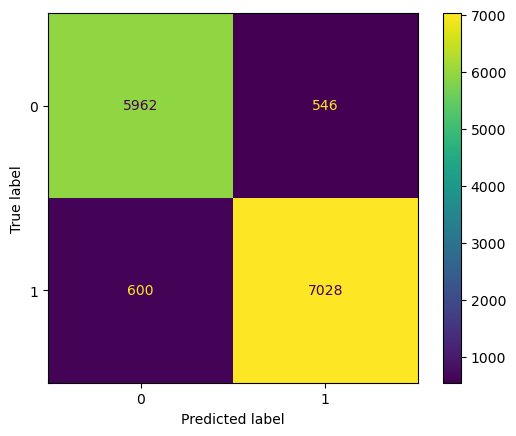

In [16]:
ConfusionMatrixDisplay.from_estimator(dtc, X_test, y_test);

In [17]:
print(classification_report(y_test, pred_dtc))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91      6508
           1       0.93      0.92      0.92      7628

    accuracy                           0.92     14136
   macro avg       0.92      0.92      0.92     14136
weighted avg       0.92      0.92      0.92     14136



If churn_risk_score is between 0 and 1, we can assume that 1 denotes a customer that is at risk of churn while 0 represents one that is not. 

This model is preforming well! We're seeing an accuracy score of nearly 92% above and solid precision, recall, and f-1. Our model seems to mislabel data in equal measure between false positives and false negatives.

## Model 2: Logistic Regression

In [18]:
lr = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)
print("model score: %.3f" % lr.score(X_test, y_test))

model score: 0.891


/opt/anaconda3/envs/narnia/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


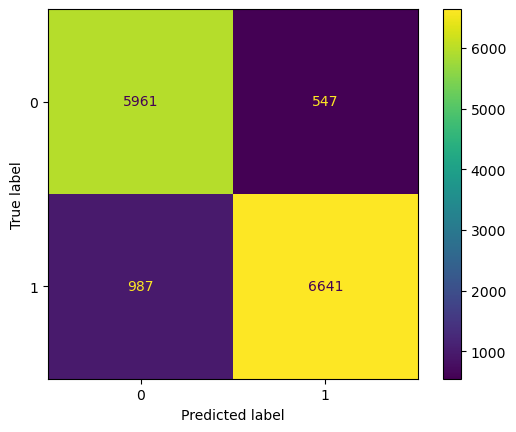

In [19]:
ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test);

In [20]:
print(classification_report(y_test, pred_lr))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      6508
           1       0.92      0.87      0.90      7628

    accuracy                           0.89     14136
   macro avg       0.89      0.89      0.89     14136
weighted avg       0.89      0.89      0.89     14136



This model performs slightly worse than our Decision Tree model, with considerably more false negatives. While precision for class 1 is slightly better here, the other scores are overall worse.

## Model 3: KNN

In [21]:
knn = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", KNeighborsClassifier())]
)

knn.fit(X_train, y_train)
pred_knn = knn.predict(X_test)
print("model score: %.3f" % knn.score(X_test, y_test))

/opt/anaconda3/envs/narnia/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/envs/narnia/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

model score: 0.787


/opt/anaconda3/envs/narnia/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


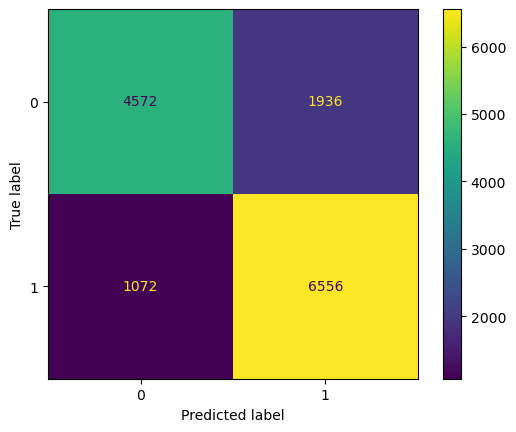

In [22]:
ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test);

In [23]:
print(classification_report(y_test, pred_knn))

              precision    recall  f1-score   support

           0       0.81      0.70      0.75      6508
           1       0.77      0.86      0.81      7628

    accuracy                           0.79     14136
   macro avg       0.79      0.78      0.78     14136
weighted avg       0.79      0.79      0.79     14136



This model also performs worse than our Decision Tree, with lower scores all around.

So far, our Decision Tree is our best model with a score of nearly 92%. It is slightly skewed towards mislabeling positives but is fairly even overall between its incorrect labeling - nearly 1k of the test set was mislabeled.

Since we're trying to understand customers who are at risk of churn, it matters more to us that we have an accurate model for telling us who is at risk versus who is not. We cannot risk false negatives because if we think a customer is not at risk of churn but they actually are, we won't be able to successfuly re-target them and retain their business. If we re-target customers who are not at risk thinking they are, it is unlikely to cause us to lose their business.

As such, we need a model that minimizes false negatives.

## Model 4: Random Forest

In [24]:
rf = Pipeline(
    steps = [("preprocessor", preprocessor), 
             ('model', RandomForestClassifier(n_estimators = 150, random_state= 42))])

rf.fit(X_train, y_train);
pred_rf = rf.predict(X_test)
print("model score: %.3f" % rf.score(X_test, y_test))

model score: 0.939


Let's try increasing the number of estimators to see if that improves the model.

In [25]:
rf2 = Pipeline(
    steps = [("preprocessor", preprocessor), 
             ('model', RandomForestClassifier(n_estimators = 400, random_state= 42))])

rf2.fit(X_train, y_train);
pred_rf2 = rf2.predict(X_test)
print("model score: %.3f" % rf2.score(X_test, y_test))

model score: 0.939


We're not seeing any change despite substantially increasing estimators. So we'll go with the first one,

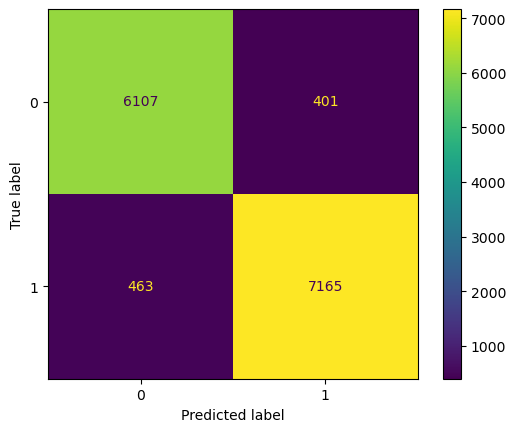

In [26]:
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test);

In [27]:
print(classification_report(y_test, pred_rf))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      6508
           1       0.95      0.94      0.94      7628

    accuracy                           0.94     14136
   macro avg       0.94      0.94      0.94     14136
weighted avg       0.94      0.94      0.94     14136



This model is doing way better than our other models, with almost 3 points on our Decision Tree model. We're also seeing less false negatives in this model, which is our goal.

## Comparing Best Models

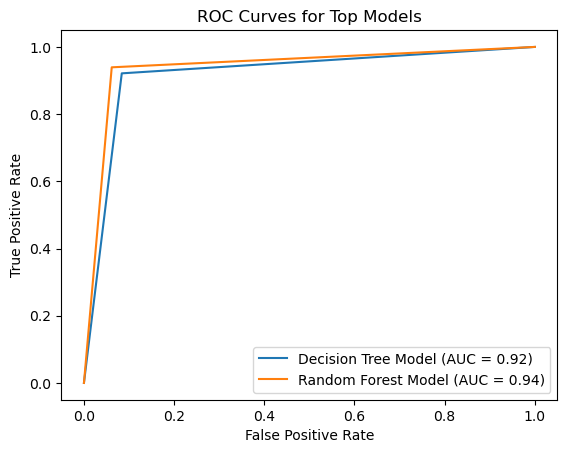

In [28]:
# Compute the false positive rate (FPR) and true positive rate (TPR) for each curve
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, pred_dtc)
fpr2, tpr2, thresholds2 = metrics.roc_curve(y_test, pred_rf)

# Compute the area under the curves (AUC) for each curve
auc1 = metrics.roc_auc_score(y_test, pred_dtc)
auc2 = metrics.roc_auc_score(y_test, pred_rf)

# Plot the ROC curves
plt.plot(fpr1, tpr1, label='Decision Tree Model (AUC = %0.2f)' % auc1)
plt.plot(fpr2, tpr2, label='Random Forest Model (AUC = %0.2f)' % auc2)

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Top Models')
plt.legend(loc='lower right')

# Show the plot
plt.show()

Comparing the ROC curve for our two better models, we see that Random Forest outperforms Decision Tree when it comes to false positives.

In [31]:
bag_class_decision = BaggingClassifier(base_estimator = DecisionTreeClassifier(random_state=42), n_estimators = 150)
bag_pipe = Pipeline([("preprocessor", preprocessor),
                      ('model',
                       bag_class_decision)])
params = {'model__base_estimator__max_depth': np.arange(4,28,4)}
cv = GridSearchCV(estimator = bag_pipe, param_grid = params, cv = 5)
cv.fit(X_train, y_train)
best_model = cv.best_estimator_
cv.best_params_

{'model__base_estimator__max_depth': 8}

In [ ]:
cvtree.best_score_